In [1]:
# https://www.dacon.io/competitions/official/235736/codeshare/2844?page=undefined&dtype=recent&ptype&fType
# https://www.kaggle.com/code/kensinnoh/energy-usage-prediction

In [2]:
# 1. 필요한 변수를 생성하고 결측치를 채우는 '전처리'
# 2. 건물별 전력사용량에 대한 분석과 이를 바탕으로 유사한 건물들로 '군집화' 하여 이들의 '패턴' 확인
# 3. 마지막으로 LSTM와 XGBoost를 활용하여 건물별로 전력사용량을 예측

In [3]:
import pandas as pd
import numpy as np
import math

# Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Malgun Gothic'; plt.rcParams['axes.unicode_minus']=False;
import seaborn as sns; #sns.set_style('whitegrid')

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss,ccf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Clustering (+알파)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from minisom import MiniSom

# Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Custom Loss Function
# SMAPE : https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch1-Time-Series.html
import keras.backend as K
 
def SMAPE(true, predicted):
    epsilon=0.1
    summ=K.maximum(K.abs(true)+K.abs(predicted)+epsilon, 0.5+epsilon)
    smape=K.abs(predicted-true)/summ*2.0
    return smape

In [5]:
train=pd.read_csv('C:\\Users\\pc\\Desktop\\energy\\train.csv',encoding='euc-kr',parse_dates=['date_time'])
test=pd.read_csv('C:\\Users\\pc\\Desktop\\energy\\test.csv',encoding='euc-kr',parse_dates=['date_time'])
submission=pd.read_csv('C:\\Users\\pc\\Desktop\\energy\\sample_submission.csv',encoding='euc-kr')

In [6]:
# 1. 필요한 변수를 생성하고 결측치를 채우는 전처리 진행
# 1) 시간 관련 변수 생성 : 먼저 train 데이터와 test 데이터에 
# 월, 일, 시간, 요일, 주말여부에 해당하는 시간 변수를 생성한다.

# 요일
def weekday(x):
    if x.dayofweek==6:
        return '일'
    elif x.dayofweek==0:
        return '월'
    elif x.dayofweek==1:
        return '화'
    elif x.dayofweek==2:
        return '수'
    elif x.dayofweek==3:
        return '목'
    elif x.dayofweek==4:
        return '금'
    else:
        return '토'
    
# 주말 여부
def weekend(x):
    if x.dayofweek in [5,6]:
        return 1
    else:
        return 0

In [7]:
train['month']=train['date_time'].dt.month
train['day']=train['date_time'].dt.day
train['hour']=train['date_time'].dt.hour
train['weekday']=train['date_time'].apply(weekday)
train['weekend']=train['date_time'].apply(weekend)

In [8]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,월,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,월,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,월,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,월,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,월,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,월,0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,월,0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,월,0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,월,0


In [9]:
test['month']=test['date_time'].dt.month
test['day']=test['date_time'].dt.day
test['hour']=test['date_time'].dt.hour
test['weekday']=test['date_time'].apply(weekday)
test['weekend']=test['date_time'].apply(weekend)
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN,8,25,0,화,0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,1,화,0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,2,화,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN,8,25,3,화,0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,4,화,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,31,19,월,0
10076,60,2020-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,31,20,월,0
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,NaN,0.0,1.0,1.0,8,31,21,월,0
10078,60,2020-08-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,31,22,월,0


In [10]:
# 2) test 결측치 채우기
print('\033[1m<test함수 변수별 결측값 수> \033[0m\n',test.isna().sum())

<test함수 변수별 결측값 수> 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
month              0
day                0
hour               0
weekday            0
weekend            0
dtype: int64


In [11]:
# 데이터를 확인하면 train 데이터에는 결측치가 없지만, test 데이터에는 결측치가 존재함을 알 수 있다.
# 변수 별로 조금씩 다른 결측치 패턴을 가지는데, 변수의 특성에 따라 다른 방법으로 결측치를 채워주도록 한다.

# [test 데이터 중 결측치 있는 변수]
# 비전기냉방설비운영, 태양광보유 : 불규칙적으로 결측값 있음
# 기온, 풍속, 습도, 일조(hr,3시간) : 3시간 단위로만 값이 있음
# 강수량 : 6시간 단위로만 값이 있음

In [12]:
# ** 결측치 채우기 : 건물 변수
# 먼저 건물 변수인 '비전기냉방설비운영','태양광보유'의 결측치를 채워준다.
# 건물 정보는 건물이 동이랗면 모든 같은 값을 가지고, test 데이터의 건물 종류는 train 데잍터의 건물 종류와 동일하므로,
# train 데이터의 건물 변수 값을 이용하여 결측값을 채워준다.

building_info=train[['num','비전기냉방설비운영','태양광보유']].drop_duplicates()

test.drop(columns=['비전기냉방설비운영','태양광보유'],inplace=True)
test=pd.merge(test,building_info,on='num')

In [13]:
# ** 결측치 채우기 : 일조
# train 데이터의 일조를 확인하면 discrete한 분포를 지님을 확인할 수 있다.
# 따라서 가장 최근에 기록된 일조 값을 가져오는 형태로 결측치를 채워준다.

train['일조(hr)'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: 일조(hr), dtype: int64

In [14]:
test['일조(hr)']=test['일조(hr, 3시간)'].interpolate(method='pad')
# https://rk1993.tistory.com/160
# 'pad' :  바로 앞에 value 사용

In [15]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",month,day,hour,weekday,weekend,비전기냉방설비운영,태양광보유,일조(hr)
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,8,25,0,화,0,0.0,0.0,0.0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,8,25,1,화,0,0.0,0.0,0.0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,8,25,2,화,0,0.0,0.0,0.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,8,25,3,화,0,0.0,0.0,0.0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,8,25,4,화,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,NaN,NaN,NaN,NaN,NaN,8,31,19,월,0,1.0,1.0,0.8
10076,60,2020-08-31 20:00:00,NaN,NaN,NaN,NaN,NaN,8,31,20,월,0,1.0,1.0,0.8
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,NaN,0.0,8,31,21,월,0,1.0,1.0,0.0
10078,60,2020-08-31 22:00:00,NaN,NaN,NaN,NaN,NaN,8,31,22,월,0,1.0,1.0,0.0


In [16]:
# ** 결측치 채우기 : 기온, 풍속, 습도, 강수량
# 기온, 풍속, 습도, 강수량은 'pad', 'linear', 'quadratic', 'cubic' 방법 중 
# train 데이터에서 가장 성능이 뛰어난 보간법으로 결측치를 채워준다.

In [17]:
# 우선 train 데이터에 임의로 결측치를 생성하도록 한다.
train_=train.copy()

In [18]:
def make_train_nan(col, n):
    new_list = []
    for idx, temp in enumerate(train_[col]):
        if idx%n==0:
            new_list.append(temp)
        else:
            new_list.append(np.nan)
    train_['{}'.format(col+'_nan')] = new_list

In [19]:
make_train_nan('기온(°C)',3)
make_train_nan('풍속(m/s)',3)
make_train_nan('습도(%)',3)
make_train_nan('강수량(mm)',6)

In [20]:
print(train_.iloc[:,-4:].isnull().sum()) # 결측치 생성

기온(°C)_nan      81600
풍속(m/s)_nan     81600
습도(%)_nan       81600
강수량(mm)_nan    102000
dtype: int64


In [21]:
# 각 변수에 대해 4가지의 보간법을 시행한 후 가장 오차가 적은 보간법으로 결측치를 채워준다.

def compare_interpolate_methods(col,methods,metric):
    error_dict=dict()
    for method in methods:
        fillna=train_['{}'.format(col+'_nan')].interpolate(method=method)
        if fillna.isna().sum()!=0:
            fillna=fillna.interpolate(method='linear')
        error=metric(train_['{}'.format(col)],fillna)
        error_dict['{}'.format(method)]=error
    
    return error_dict

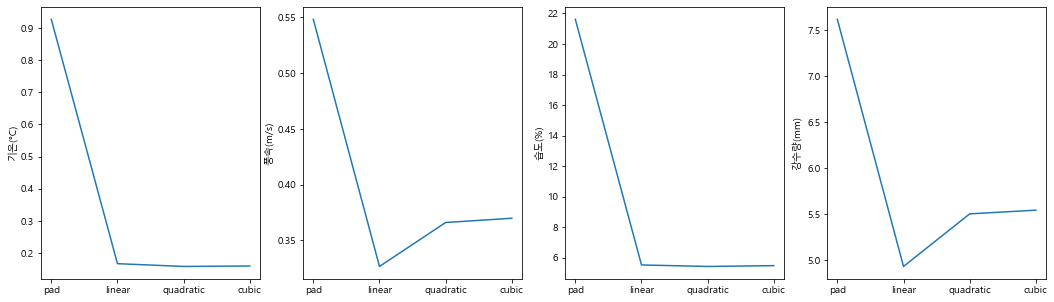

In [22]:
all_cols_error_dict=dict()
for col in ['기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']:
    methods=['pad','linear','quadratic','cubic']
    error_dict=compare_interpolate_methods(col,methods,mean_squared_error)
    all_cols_error_dict['{}'.format(col)]=error_dict
    
all_cols_error_df=pd.DataFrame(all_cols_error_dict)

fig,axes=plt.subplots(1,4,figsize=(18,5),sharey=False)
for i in range(len(all_cols_error_df.columns)):
    sns.lineplot(ax=axes[i],data=all_cols_error_df.iloc[:,i].transpose())

In [23]:
# 기온 결측치 채우기
test['기온(°C)'].interpolate(method='quadratic')
# 마지막 na 채우기
test['기온(°C)']=test['기온(°C)'].interpolate(method='linear')

# 풍속 결측치 채우기
test['풍속(m/s)']=test['풍속(m/s)'].interpolate(method='linear')

# 습도 결측치 채우기
test['습도(%)']=test['습도(%)'].interpolate(method='quadratic')
# 마지막 na 채우기
test['습도(%)']=test['습도(%)'].interpolate(method='linear')

# 강수량 결측치 채우기
test['강수량(mm)']=test['강수량(mm, 6시간)'].interpolate(method='linear')

In [24]:
# 3) 불쾌지수 생성
# 불쾌지수란 기온과 습도의 조합으로 사람이 느끼는 온도를 표현한 거스로 온습도지수(THI)라고도 한다.
# 불쾌지수는 여름철 실내의 무더위의 기준으로서만 사용되고 있을 뿐, 복사나 바람의 조건은 포함되어 있지 않다. 
# 때문에 그 적정한 사용에는 한계가 있다는 점에 유의해야 한다.
# 해당 데이터가 여름철 데이터인만큼 실내 전력사용량과 관련이 있을 것이라고 판단했다.

In [25]:
# 날씨 변수를 이용하여 쾌적함의 척도로써 여름철 에어컨 사용 등 전력 사용량에 영향을 미칠 것으로 예상되는
# '불쾌지수' 추가
train['불쾌지수']=1.8*train['기온(°C)']-0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(°C)']-26)+32
test['불쾌지수'] = 1.8*test['기온(°C)'] - 0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(°C)']-26) + 32

In [26]:
# 4) 체감온도 생성
# 체감온도는 불쾌지수에서 포함하지 않은 바람의 조건을 포함하고 있어 보완해주는 변수라고 판단했다.
train['체감온도']=13.12+0.6215*train['기온(°C)']-13.947*train['풍속(m/s)']**0.16+0.486*train['기온(°C)']*train['풍속(m/s)']**0.16
test['체감온도']=13.12+0.6215*test['기온(°C)']-13.947*test['풍속(m/s)']**0.16+0.486*test['기온(°C)']*test['풍속(m/s)']**0.16

In [27]:
# (데이터프레임 변수 순서 정리)
train = train[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','체감온도','풍속(m/s)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','전력사용량(kWh)']]
test = test[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','체감온도','풍속(m/s)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유']]

In [28]:
### 2. Exploratory Data Analysis ###
# '건물별' 전력사용량의 예측 및 분석을 하고자 건물 관련 정보를 적극 이용하고자 했다.
# 하지만 주어진 데이터에 주어진 건물 관련 자료는 건물 번호, 비전기냉방설비운영, 태양광보유 3가지의 변수로 제한적인 정보 뿐이라, 
# 건물 관련 더 자세한 정보가 있으면 좋을 것 같다는 판단 하에, [용도에 따른 건축물 분류]를 적용했다.

# 데이터 설명에서 주어진 건물 관련 용도는 아파트, 병원, 확교 등 7가지 용도의 건물이라는 사실을 바탕으로
# 나머지 건물의 용도를 추측했다.

# 보편적으로 사용되는 해당 기준을 적용하여 다양한 기준에 따라 건물의 용도를 추측하고, 
# 그 결과 용도에 맞는 사업 및 전력사용량 절약 방법에 대해 제시할 수 있을 것이라고 생각했다.

# 이 때 사용된 기준은 IBC(International Building Code)로 건축물을 용도에 따라 10가지로 구분한 볍규이다.

<AxesSubplot:xlabel='전력사용량(kWh)', ylabel='Count'>

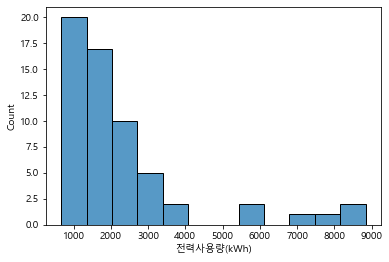

In [29]:
# 1) 전력 사용량 기본 EDA
# 건물들의 평균 전력사용량

sns.histplot(train.groupby('num')['전력사용량(kWh)'].mean())

In [30]:
# 한 시간에 평균 1000kWh를 쓰는 건물부터 9000kWh를 쓰는 건물까지 
# 건물마다 전력사용량의 총량이 매우 다양하다는 것을 확인할 수 있다.

In [31]:
# 건물 변수와 전력사용량의 관계
train.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean()

비전기냉방설비운영  태양광보유
0.0        0.0      2077.030506
           1.0      1582.298192
1.0        0.0      2101.993590
           1.0      2949.726621
Name: 전력사용량(kWh), dtype: float64

In [32]:
# 일반적으로 비전기냉방설비를 운영하고 태양광을 보유하면 전력사용량이 더 적을 것으로 예상할 수 있다.

# 건물별 거주인구, 유동인구 및 건물면적 등의 정보를 모르기 때문에 
# 주어진 건물 변수와 전력사용량의 관계를 정확히 알 수는 없지만, 
# 예상과 달리 비전기 냉방설비 운영 여부, 태양광 보유 여부가 건물의 전력사용량을 낮춰주진 않는다는 것을 확인할 수 있다.

<AxesSubplot:>

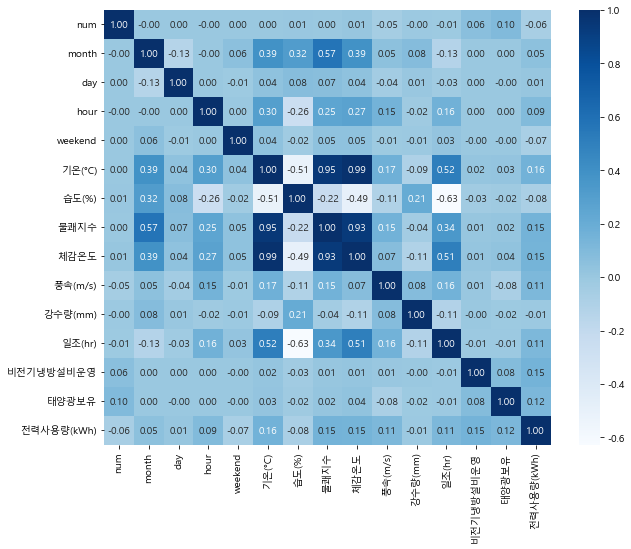

In [33]:
# [건물별 전력사용량과 다른 변수들의 상관관계]
plt.figure(figsize=(10,8))
sns.heatmap(data=train.corr(),annot=True,fmt='.2f',cmap='Blues')

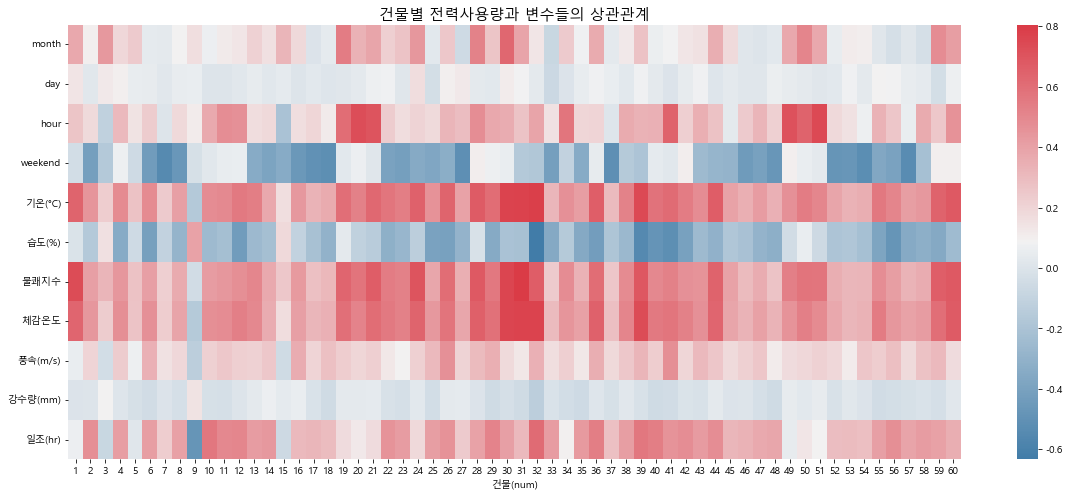

In [34]:
corr=[]
for num in range(1,61):
    df=train[train.num==num]
    num_corr=df.corr()['전력사용량(kWh)']
    num_corr=num_corr.drop(['num','비전기냉방설비운영','태양광보유','전력사용량(kWh)'])
    corr.append(num_corr)
corr_df=pd.concat(corr,axis=1).T
corr_df.index=list(range(1,61))

# 시각화
f,ax=plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계",fontsize=15)
sns.heatmap(corr_df.T,cmap=sns.diverging_palette(240,10,as_cmap=True),ax=ax)
plt.xlabel('건물(num)')
plt.show()

In [35]:
## 건물별로 전력사용량과의 각 변수들의 상관계수가 다름을 알 수 있다. 예를 들어,
# - 건물 1 : 기온과 강한 양의 상관관계를 가지고,
# - 건물 2 : 기온과는 상관관계가 거의 없고, 일조와 음의 상관관계를 가진다.

# 이후 전력사용량을 모델링할 때 이를 기반으로 [건물별로 다른 변수]를 사용하도록 한다.

In [36]:
### 추가변수와 각 건물의 전력 사용량 평균 시각화 ###
# 위에서 기상청에서 제공하는 생활기상지수 중 '불쾌지수'와 '체감온도'를 새로운 변수로 생성했다.
# 이에 따라 기상청에서 제공하는 기준에 따라 '불쾌지수'와 '체감온도'를 카테고리화 했다.

## 불쾌지수 ##
# x >= 80 : 매우 높음
# 75 <= x < 80 : 높음
# 68 <= x < 75 : 보통
# x < 68 : 낮음

print(train['불쾌지수'].min())
print(train['불쾌지수'].max())

52.344210000000004
86.66179


In [37]:
train['불쾌지수_c']=pd.cut(train.불쾌지수,bins=[50,68,75,80,90],labels=['낮음','보통','높음','매우높음'])

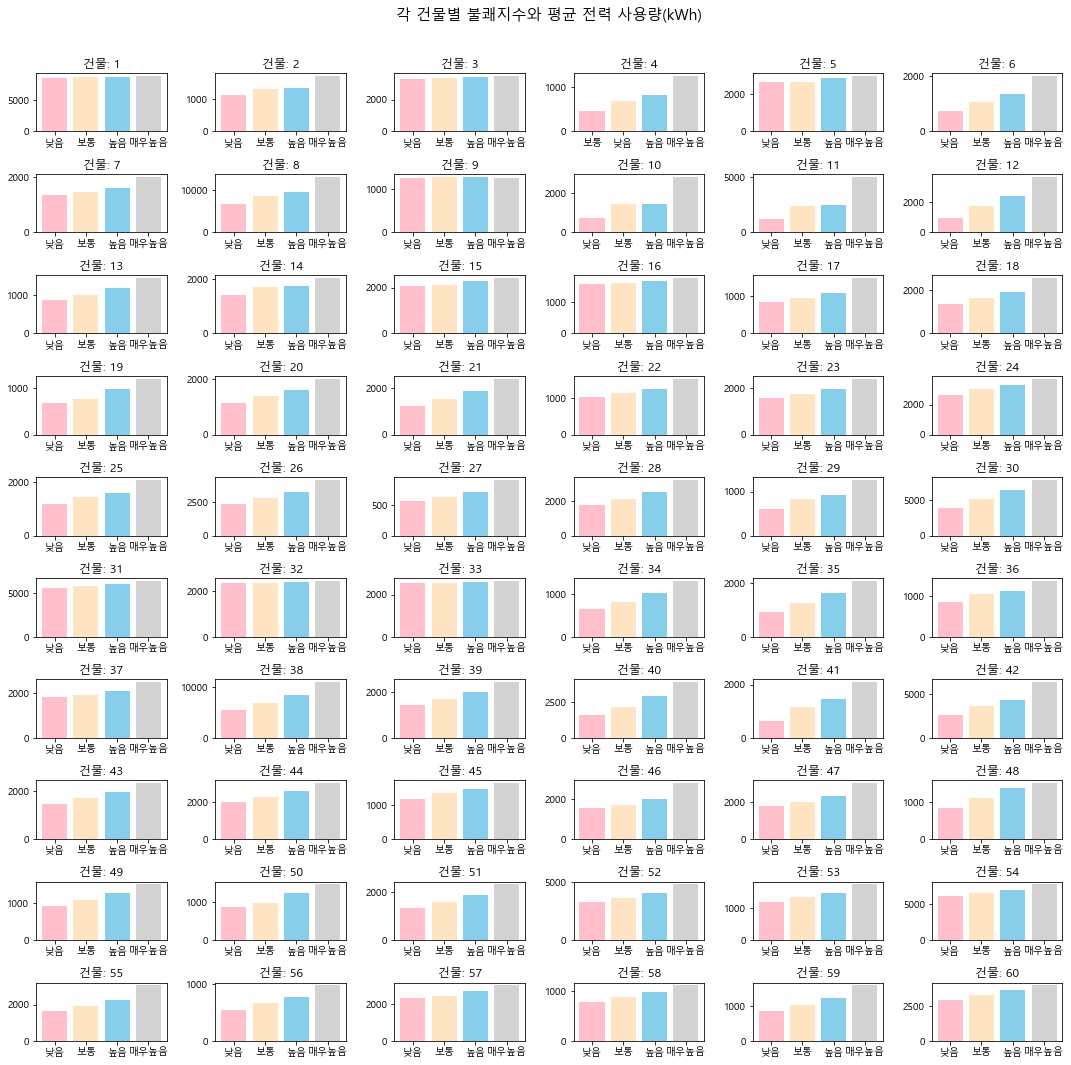

In [38]:
# 불쾌지수
fig=plt.figure(figsize=(15,15))
plt.title("각 건물별 불쾌지수와 평균 전력 사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

colors=['pink','bisque','skyblue','lightgrey']

for num in range(1,61):
    df=train[train.num==num]
    df_counts=df.groupby('불쾌지수_c')['전력사용량(kWh)'].mean()
    ax=fig.add_subplot(10,6,num)
    ax.bar(df['불쾌지수_c'].unique(),df_counts,color=colors)
    ax.set_title(f'건물: {num}')
    
plt.tight_layout()
plt.show()

In [39]:
# 건물별 불쾌지수와 평균 전력사용량을 시각화한 결과이다.
# 불쾌지수와 관련없이 전력사용량의 평균이 비슷한 케이스와 불쾌지수가 높을 수록 전력사용량이 늘어나는
# 두 가지의 케이스로 나누어서 볼 수 있다.

# 1. 불쾌지수의 수준과 전력사용량의 차이가 거의 없는 건물
# 예시 : 건물 1,3,5,9,15,16,31,32,33
# 예측 : 공장, 저장(창고) 등

# 2. 불쾌지수의 수준이 높아질수록 전력사용량이 증가하는 건물
# 예시 : 건물 2,4,6,7,8,10,11,12,13,14,17-30, 34-60
# 예측 : 주거, 집회, 사업 등

# > 2번의 경우, 사람들이 직접 이용하는 건물일 확률이 높다고 판단하였고,
# > 반대로 1번의 경우 사람들의 사용보다 건물 자체의 이용이 주가 되는 용도의 건물일 것이라고 판단

In [40]:
## 체감온도 ##
# t >= 31 : 매우 위험
# 28 <=t< 31 : 위험
# 25 <=t< 28 : 경고
# 21 <=t< 25 : 주의
# t< 21 : 관심

print(train['체감온도'].min())
print(train['체감온도'].max())

11.940652931164212
39.70264167119042


In [41]:
train.loc[train['체감온도']>=31, '체감온도_b']='매우\n위험'
train.loc[(train['체감온도']>=28)&(train['체감온도']<31), '체감온도_b']='위험'
train.loc[(train['체감온도']>=25)&(train['체감온도']<28), '체감온도_b']='경고'
train.loc[(train['체감온도']>=21)&(train['체감온도']<25), '체감온도_b']='주의'
train.loc[train['체감온도']<21,'체감온도_b']='관심'

In [42]:
train['체감온도_b'].unique()

array(['관심', '주의', '경고', '위험', '매우\n위험'], dtype=object)

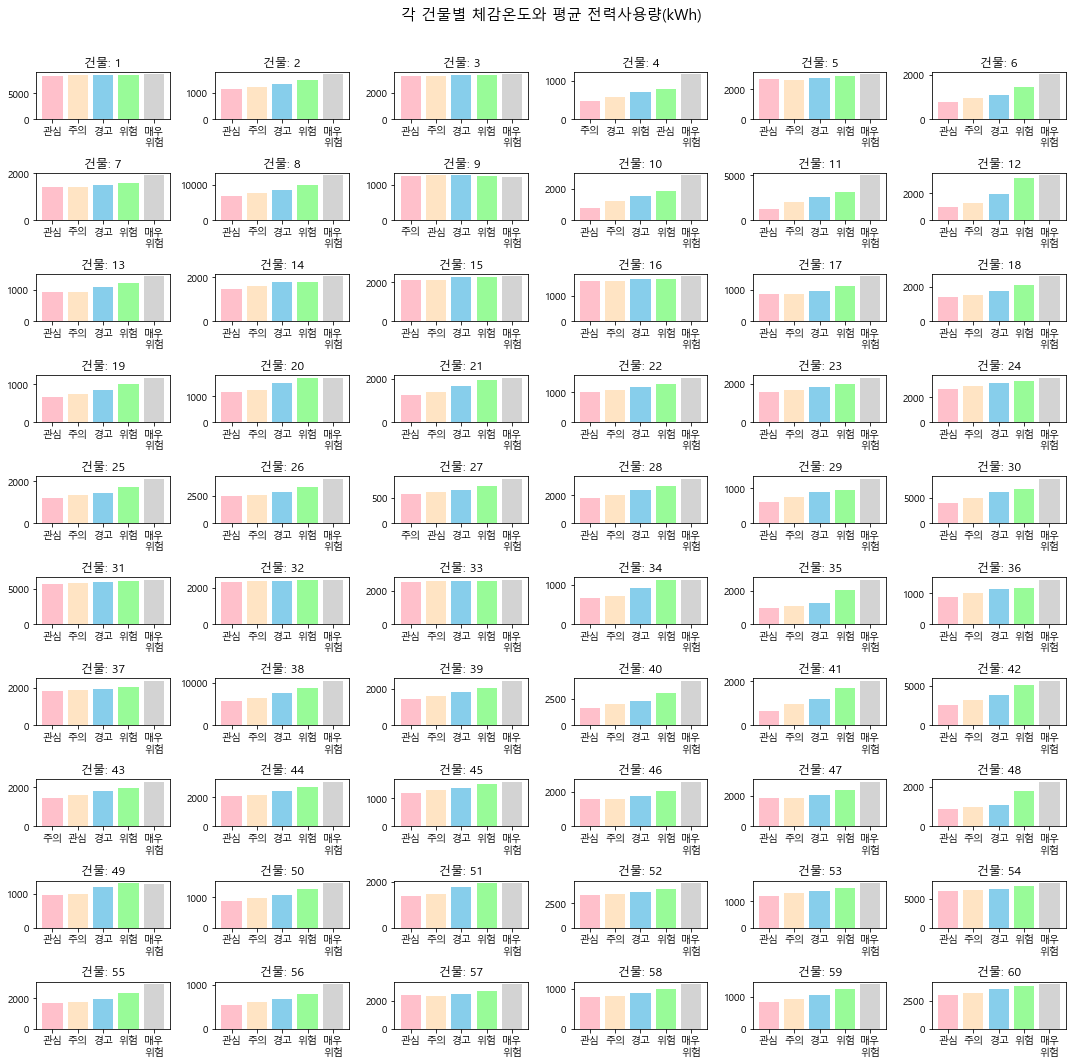

In [43]:
# 체감온도
fig=plt.figure(figsize=(15,15))
plt.title("각 건물별 체감온도와 평균 전력사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

colors=['pink','bisque','skyblue','palegreen','lightgrey']
sensible_temp=train['체감온도_b'].unique()

for num in range(1,61):
    df=train[train.num==num]
    df_counts=df.groupby('체감온도_b')['전력사용량(kWh)'].mean()
    df_counts=df_counts.reindex(sensible_temp)
    ax=fig.add_subplot(10,6,num)
    ax.bar(df['체감온도_b'].unique(),df_counts,color=colors)
    ax.set_title(f'건물: {num}')
    
plt.tight_layout()
plt.show()

In [44]:
train['체감온도_b'].value_counts()

주의        38824
경고        36151
위험        23044
매우\n위험    12344
관심        12037
Name: 체감온도_b, dtype: int64

In [45]:
# 건물별 체감온도와 평균 전력사용량을 시각화한 결과이다.
# 체감온도와 관련없이 전력사용량의 평균이 비슷한 케이스와, 체감온도가 '경고'일 때 가장 높은 건물들
# 두 가지의 케이스로 나누어 볼 수 있다.

# 1. 체감온도의 수준과 전력사용량의 차이가 없는 건물
# - 예시 : 건물 1,3,5,9,15,16,31,32,33
# - 예측 : 공장, 저장(창고) 등

# 2. 체감온도의 수준이 높아질수록 전력사용량이 증가하는 건물
# - 예시 : 2,4,6,7,8,10,11,12,13,14,17-30, 34-60
# - 예측 : 주거, 집회, 사업 등

# > 체감온도와 평균 전력사용량의 시각화를 통해 나눈 두 분류가 위 불쾌지수를 통해 나눈 분류와
# '동일한 결과'를 나타냄을 알 수 있다.

# > 사람의 이용인지, 건물 자체의 사용인지에 따라 상이한 전력사용량 및 비용 절약 방법을 추천할 수 있다.

In [46]:
## 2) 시계열 분석
# 건물별로 시계열 분포가 다르므로 대표로 2개의 건물(건물 4, 건물9)에 대해 
# 시계열 분석을 하여 어떤 시계열적 특징이 있는지 확인해보겠다.

In [47]:
## 시계열 분해
# 우선 시계열 분해를 통해 건물별 전력사용량을 추세, 계절성, 잔차로 분해했다.

def vis_time_series_decompose(num):
    df=train[train.num==num]
    df.index=df.date_time
    
    res=sm.tsa.seasonal_decompose(df['전력사용량(kWh)'],model='additive')
    
    fig, (ax1, ax2, ax3, ax4)=plt.subplots(4,1,figsize=(20,12))
    res.observed.plot(ax=ax1,title='Observed')
    res.trend.plot(ax=ax2,title='Trend')
    res.resid.plot(ax=ax3,title='Residual')
    res.seasonal.plot(ax=ax4,title='Seasonal')
    plt.tight_layout()
    plt.show()

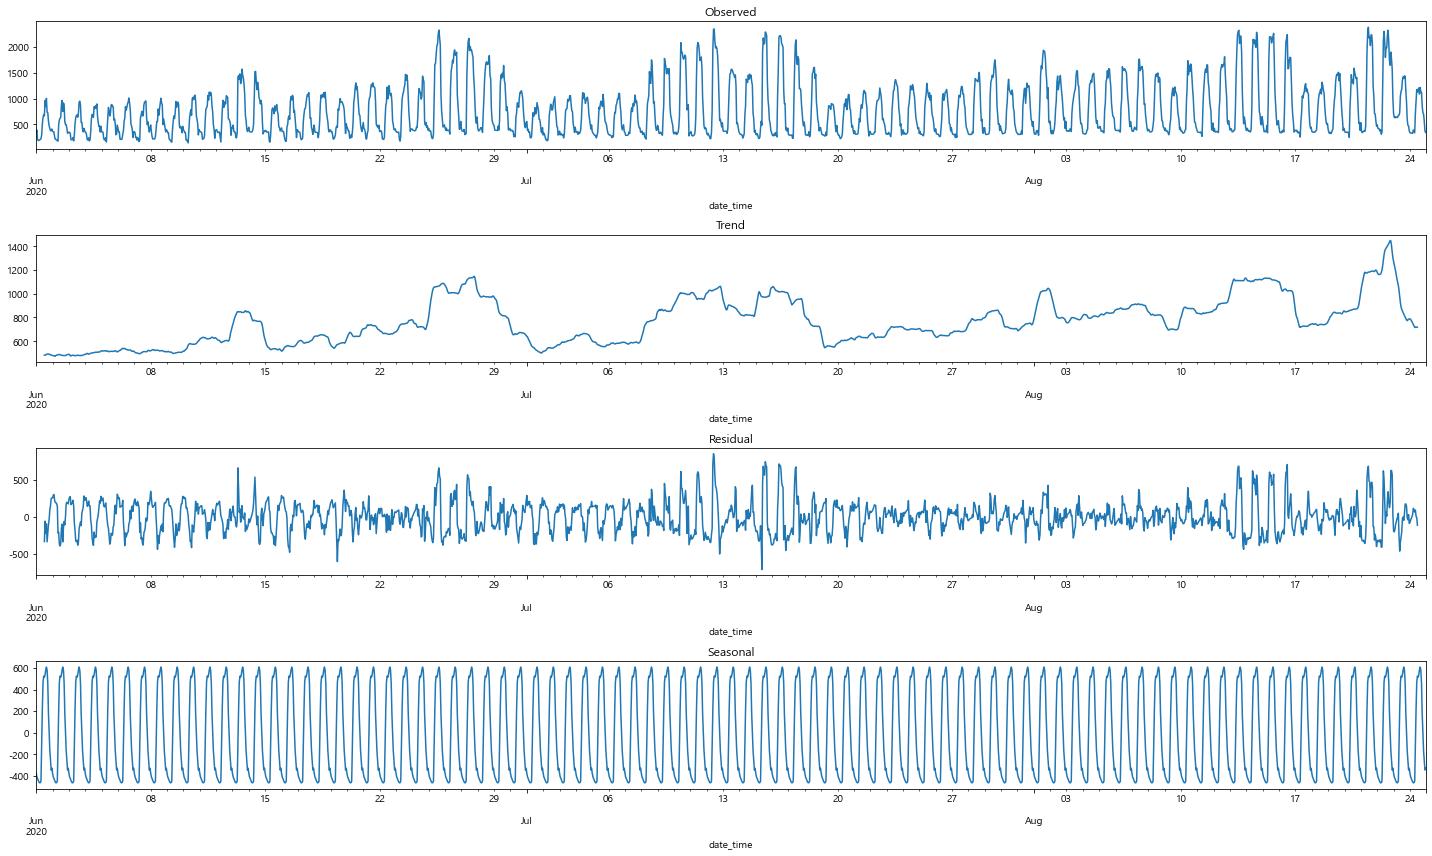

In [48]:
## 건물 4
vis_time_series_decompose(num=4)

In [49]:
# 건물 9의 경우, 마찬가지로 하루를 주기로 계절성을 지님을 알 수 있다.
# 또한 85일동안 특별히 증가하거나 감소하는 추세는 보이지 않는다.

# > 두 건물 모두 '하루 단위의 계절성이 존재함'으로 
# '하루 단위'로 시간에 따른 전력사용량을 관찰할 필요가 있음을 알 수 있다.

# 따라서 아래에 건물별로 시간별 평균 전력사용량에 대한 분석을 진행했다.

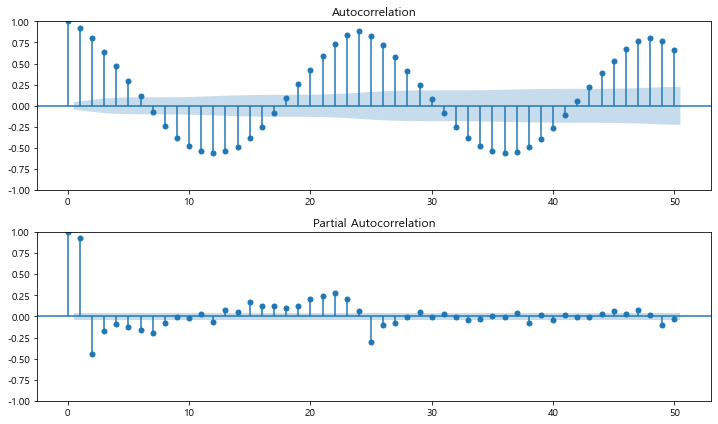

In [50]:
## 자기상관 & 부분자기상관

## 건물 4
df=train[train.num==4]
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(10,6))
plot_acf(df['전력사용량(kWh)'],lags=50,ax=ax1)
plot_pacf(df['전력사용량(kWh)'],lags=50,ax=ax2)
plt.tight_layout()
plt.show()

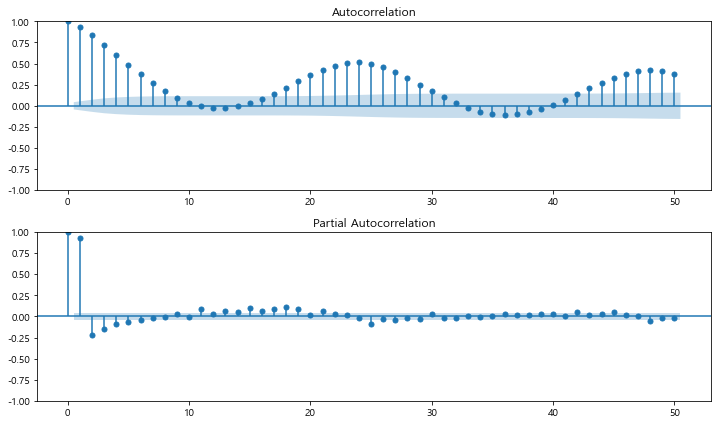

In [51]:
## 건물 9
df=train[train.num==9]
fig, (ax1, ax2)=plt.subplots(nrows=2,figsize=(10,6))
plot_acf(df['전력사용량(kWh)'], lags=50,ax=ax1)
plot_pacf(df['전력사용량(kWh)'],lags=50,ax=ax2)
plt.tight_layout()
plt.show()

In [52]:
# PACF를 봤을 때 두 건물 모두 전력사용량은 1시간, 2시간 전과 크게 관계가 있고,
# 약 24시간 전의 전력사용량에도 약간의 영향을 받음을 확인할 수 있다.
# 따라서 이후 시계열 예측을 진행할 때 직전 시간뿐만 아니라, 24시간 전의 데이터도 활용하여 학습했다.

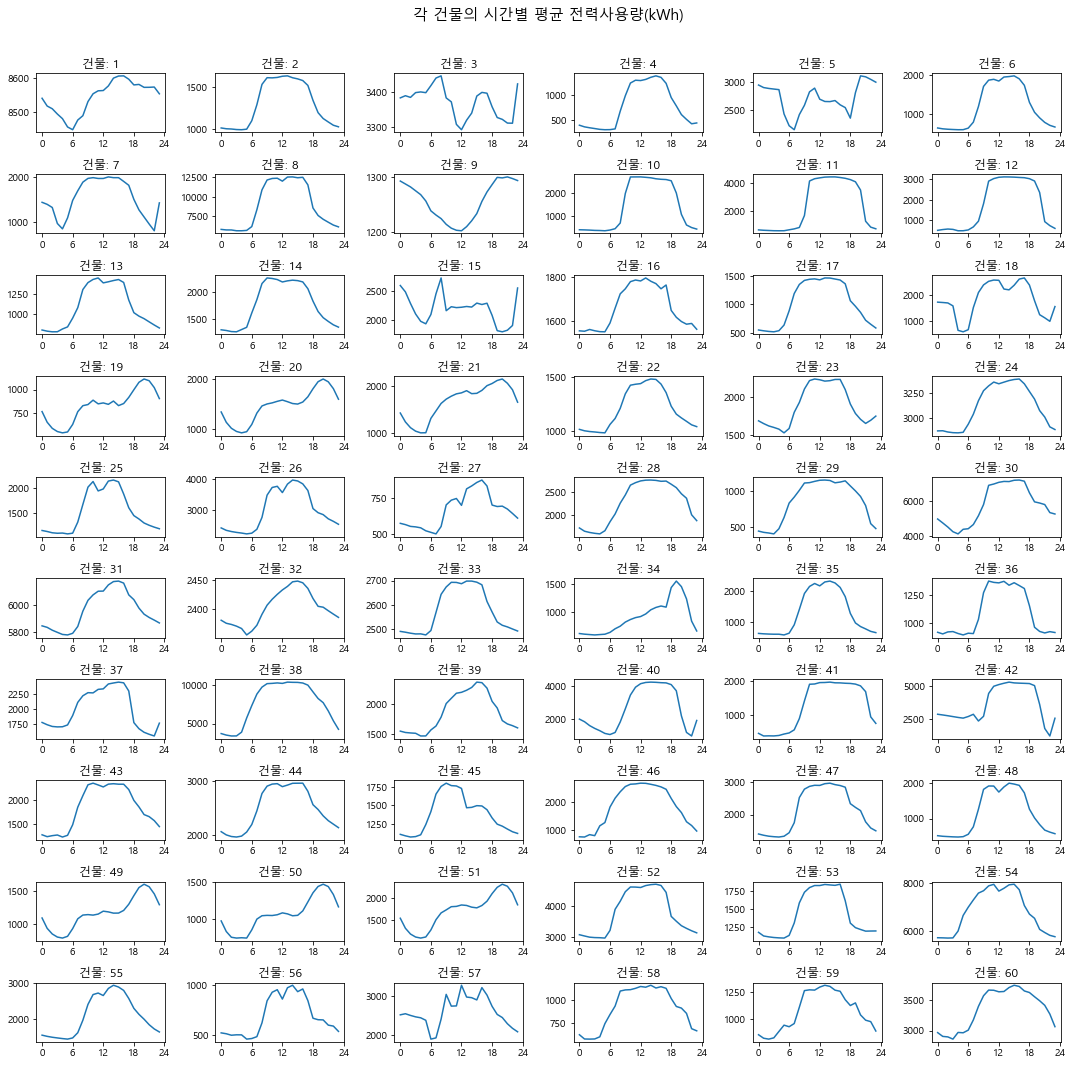

In [53]:
# 3) 각 건물의 시간에 따른 평균 전력사용량 시각화
# 시간별 평균 전력사용량

fig=plt.figure(figsize=(15,15))
plt.title("각 건물의 시간별 평균 전력사용량(kWh)",fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df=train[train.num==num]
    ax=fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(),df.groupby('hour')['전력사용량(kWh)'].mean())
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
plt.tight_layout()
plt.show()

In [54]:
# 건물들은 하루동안 시간별로 각각 다르지만 또 비슷한 전력 사용 패턴을 보인다.
# 눈에 띄는 패턴에 따라 건물들을 나눠 분석해보았다.

# 1. 6시에 전력사용량이 증가하여 9시~18시까지 전력사용량이 많은 건물
# - 예시 : 2,4,6,8 등
# - 용도 추측 : 상가, 사무실이 많은 회사 건물

# 2. 1번 패턴과 비슷하나 12시쯤에 전력이 약간 줄어드는 건물
# - 예시 :6,8,13,14 등
# - 용도 추측 : 점심시간을 갖는 회사가 모인 건물

# 3. 1번 패턴과 비슷하나 자정쯤에 전력량이 상승하는 건물
# - 예시: 7, 18, 23, 42 등
# - 용도 추측:새벽에 서버를 돌리는 회사가 있는 건물

# 4. 6시부터 상승하여 16시까지 비슷하다가 이후 20시쯤 피크를 찍는 건물
# - 예시: 19, 20, 21, 49 등
# - 용도 추측: 학원이 많은 건물, 24시간 카페가 있는 건물

# 5. 저녁~새벽에 전력사용량이 많은 건물
# - 예시: 9 등
# - 용도 추측: 저녁에 영업하는 주점 등이 있는 상가 건물일 가능성 높음

# 이외에도 건물3의 경우 8시, 16시쯤 피크를 찍는 형태를 보이는 등의 패턴을 보인다.

In [55]:
## 요일별 평균 전력사용량

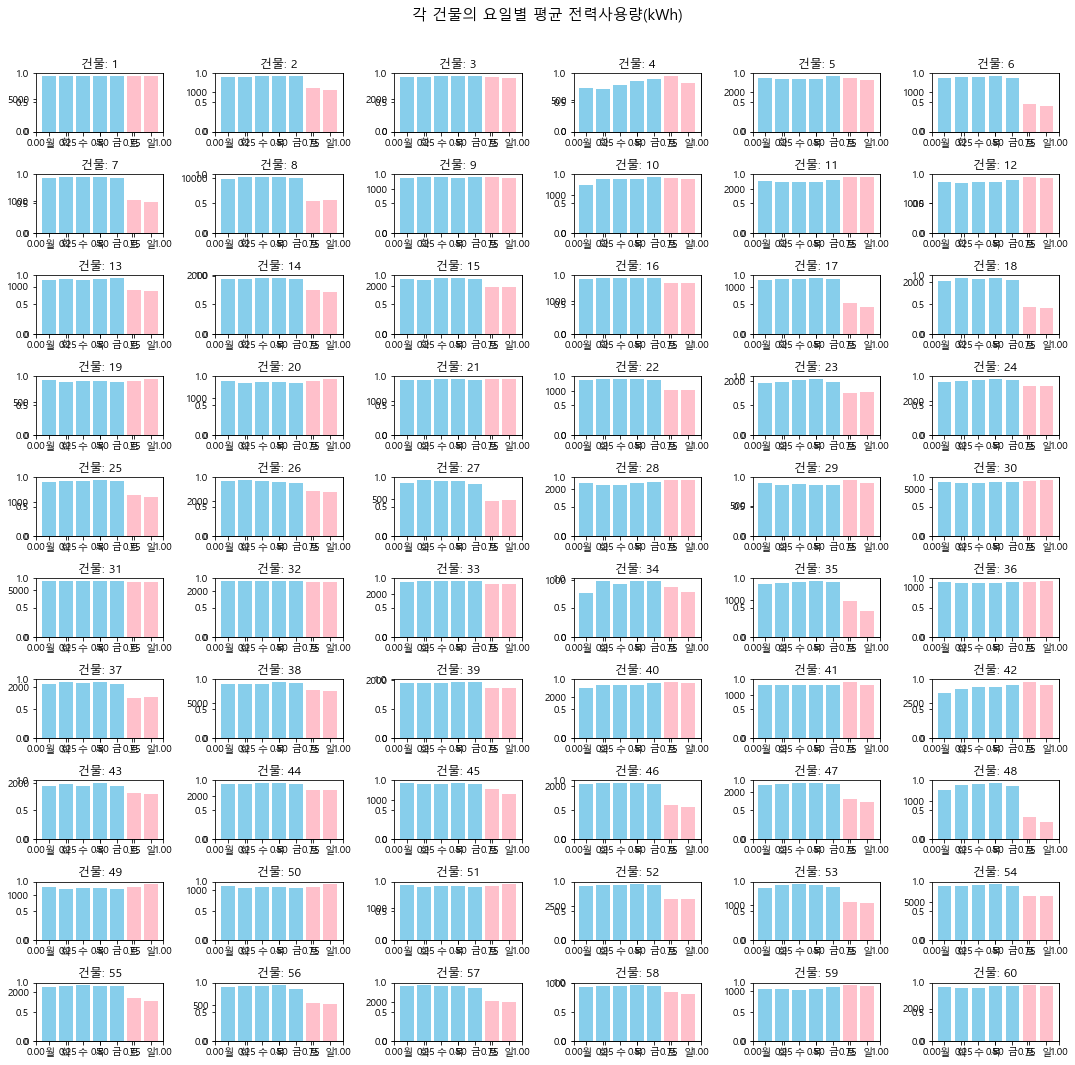

In [56]:
fig=plt.figure(figsize=(15,15))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)",fontsize=15, y=1.05)
plt.axis("off")

weekday=['월','화','수','목','금','토','일']
colors=['skyblue','skyblue','skyblue','skyblue','skyblue','pink','pink']

for num in range(1,61):
    df=train[train.num==num]
    df_counts=df.groupby('weekday')['전력사용량(kWh)'].mean()
    df_counts=df_counts.reindex(weekday)
    ax=fig.add_subplot(10,6,num)
    ax=fig.add_subplot(10,6,num)
    ax.bar(df['weekday'].unique(),df_counts,color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

In [57]:
# 일주일동안의 전력사용량을 요일별로 보면 크게 3가지 패턴으로 나뉜다.
# 각 패턴에 따라 건물들을 나눠 분석해보았다.

# 1. 주말에 사용량이 감소하는 건물
# - 예시 : 2,6,7 등
# - 용도 추측 : 사무실이 많은 회사 건물, 학교

# 2. 주말에 사용량이 약간 증가하는 건물
# - 예시 : 11,12 등
# - 용도 추측 : 주거용 건물
 
# 3. 요일 상관없이 사용량이 일정한 건물
# - 예시 : 1,9 
# - 용도 추측 : 대학병원

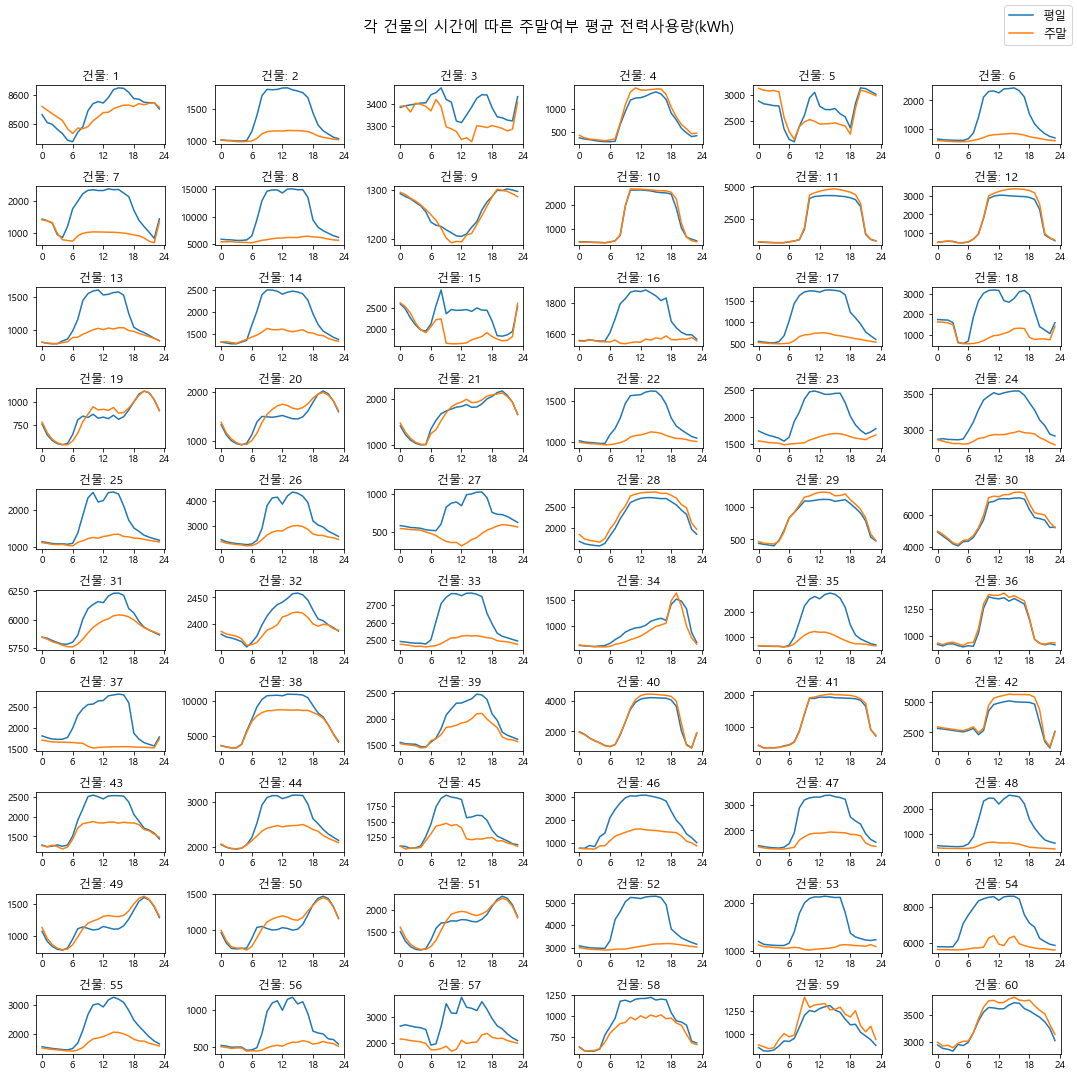

In [58]:
## 시간 + 요일별 평균 전력사용량
fig=plt.figure(figsize=(15,15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)",fontsize=15,y=1.05)
plt.axis('off')

for num in range(1,61):
    df=train[train.num==num]
    ax=fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(),df[df.weekend==0].groupby('hour')['전력사용량(kWh)'].mean(),label='평일')
    ax.plot(df['hour'].unique(),df[df.weekend==1].groupby('hour')['전력사용량(kWh)'].mean(),label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])

lines,labels=fig.axes[-1].get_legend_handles_labels()
fig.legend(lines,labels,loc=1,prop={'size':12})
plt.tight_layout()
plt.show()

In [59]:
# 마지막으로 평일과 주말을 나눠 하루동안의 전력사용량을 시각화하였다.
# 마찬가지로 패턴에 따라 건물들을 나눠보았다.

# 1. 평일과 주말의 패턴이 비슷한 건물
# - 예시 : 4,9,10 등

# 2. 평일과 줌라의 낮시간대의 사용량이 차이나는 건물
# - 예시 : 2,6,7 등

# 3. 평일과 주말의 패턴이 반대인 건물
# - 예시 : 27

In [60]:
# 건물마다 시간에 따른 패턴이 다르지만 일정한 기준에 의해 묶을 수 있을 것으로 보인다.
# 따라서 '군집화'를 통해 비슷한 패턴을 가진 건물끼리 묶어보도록 한다.

### 3. 군집화 ###
# KMeans와 SOM의 두 가지 알고리즘을 사용하여 건물을 군집화하였다.
# 우선 이에 필요한 함수를 생성하였다.

## 시계열 군집화용 DataFrame을 생성하는 함수(row->num, col->date_time)
def cluster_df(scaler=MinMaxScaler()): # scaler=[False,'MinMaxScaler()','StandardScaler()']
    train_=train.copy()
    train_ts=train_.pivot_table(values='전력사용량(kWh)', index=train_.num, columns='date_time',aggfunc='first')
    
    if scaler:
        train_ts_T=scaler.fit_transform(train_ts.T)
        train_ts=pd.DataFrame(train_ts_T.T,index=train_ts.index,columns=train_ts.columns)
        
    return train_ts

In [61]:
## SOM 알고리즘 결과를 정리해주는 DataFrame을 생성하는 ㅎ마수
def make_som_df(X):
    win_map=som.win_map(X)
    som_result=[]
    for i in range(60):
        som_result.append([i+1,som.winner(X[i])])
    som_df=pd.DataFrame(som_result,columns=['num','cluster'])
    return som_df

In [62]:
## 여러 n_cluster에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts,n_lists=[3,4,5,6],metric='dtw',seed=2021,vis=True):
    
    if vis:
        fig=plt.figure(figsize=(20,5))
        plt.title("군집 개수별 건물수 분포",fontsize=15,y=1.2)
        plt.axis('off')
    
    for idx,n in enumerate(n_lists):
        ts_kmeans=TimeSeriesKMeans(n_clusters=n,metric=metric,random_state=seed)
        train_ts['cluster(n={})'.format(n)]=ts_kmeans.fit_predict(train_ts)
        score=round(silhouette_score(train_ts,train_ts['cluster(n={})'.format(n)],metric='euclidean'),3)
        
        vc=train_ts['cluster(n={})'.format(n)].value_counts()
        
        if vis:
            ax=fig.add_subplot(1,len(n_lists),idx+1)
            sns.barplot(x=vc.index,y=vc,palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n,score))
    if vis:
        plt.tight_layout()
        plt.show()
        
    return train_ts

In [63]:
## 여러 n_cluster에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visaulize_n_cluster(trian_ts,n_lists=[3,4,5,6],metric='dtw',seed=2021,vis=True):

    if vis:
        fig=plt.figure(figsize=(20,5))
        plt.title("군집 개수별 건물수 분포",fontsize=15,y=1.2)
        plt.axis('off')
        
    for idx,n in enumerate(n_lists):
        ts_kmeans=TimeSeriesKMeans(n_clusters=n,metric=metric,random_state=seed)
        train_ts['cluter(n={})'.format(n)]=ts_kmeans.fit_predict(train_ts)
        score=round(silhouette_score(train_ts,train_ts['cluster(n={})'.format(n)],metric='euclidean'),3)
        
        vc=train_ts['cluster(n={})'.format(n)].value_counts()
        
        if vis:
            ax=fig.add_subplot(1,len(n_lists),idx+1)
            sns.barplot(x=vx.index,y=vc,palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n,score))
    
    if vis:
        plt.tight_layout()
        plt.show()
        
    return train_ts

In [64]:
## 클러스터 별 시간 & 요일별 전력사용량 평균 시각화
def visualize_by_cluster(df_with_labels, n_cluster, algorithm):
    global labels
    global df
    
    fig = plt.figure(figsize = (20 ,4*n_cluster))
    plt.title('군집 수가 {}개일 때 각 군집별 시계열분포'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')
    
    if algorithm=='kmeans':
        labels = df_with_labels['cluster(n={})'.format(n_cluster)]
    elif algorithm=='som':
        labels = df_with_labels.cluster
        
    idx=1
    for label in set(labels): # 각 군집에 대해
        
        if algorithm=='kmeans':
            df = train[train.num.isin(list(labels[labels==label].keys()))]
        elif algorithm=='som':
            df = train[train.num.isin(som_df[som_df.cluster==label].num.values)]
        
        hour = df.hour.unique()
        weekday = df.weekday.unique()
        
        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 시간별 평균 전력사용량'.format(label))
        ax.set_xticks(hour)
        for num in df.num.unique():
            df_one = df[df.num==num]
            sns.lineplot(x=hour, y=df_one.groupby('hour')['전력사용량(kWh)'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=hour, y=df.groupby('hour')['전력사용량(kWh)'].mean(), color='red')
        
        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 요일별 평균 전력사용량'.format(label))
        for num in df.num.unique():
            df_one = df[df.num==num]
            df_one_counts = df_one.groupby('weekday')['전력사용량(kWh)'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('weekday')['전력사용량(kWh)'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['총 {}개 건물'.format(df.num.nunique())], loc=1)

    plt.show()

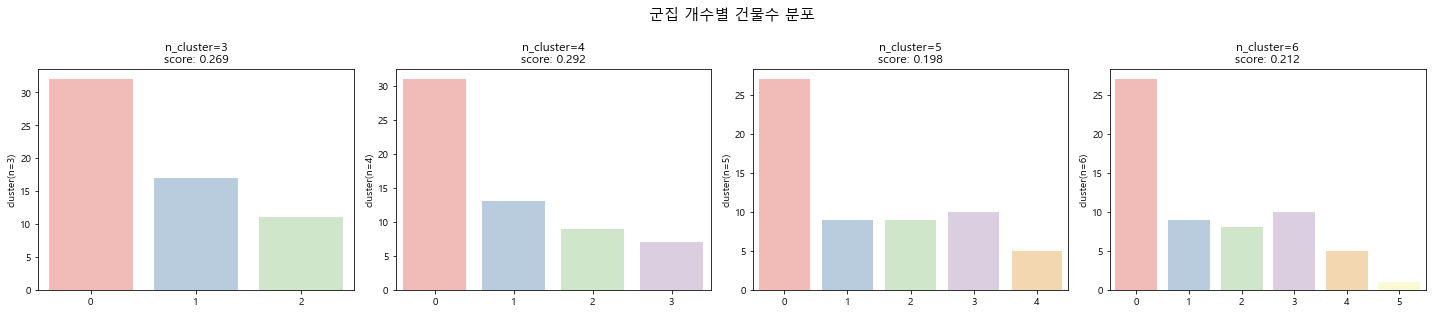

In [65]:
# 1) Time-Series KMeans
# 첫 번째로 Time-Series KMeans 알고리즘을 이용하여 전력사용랴에 따라 건물을 군집화하였다.
# 이 때, 전력사용량 StandardScaler를 이용하여 표준화하여 건물별 전력의 절대적 사용량이 아닌 
# 사용 패턴을 사용하여 군집화하도록 하였다.

# 또한 각 관측기간의 거리를 계산할 대는 euclidean 거리를 사용하였다. 시계열 데이터에서는 시간대가 다르더라도
# 계산할 수 있다는 장점을 지닌 DTW(Dynamic Time Warping) 거리 계산 방법도 많이 사용하지만, 
# 우리의 데이터는 건물별로 측정 기간이기 때문에 속도가 빠른 [euclidean 거리 계산 방법]을 사용하였다.

# 군집수의 범위는 위에서 건물별 평균 전력사용량을 시각화하였을 때 크게 3~6개의 패턴을 확인하였으므로 
# 군집수를 3,4,5,6개로 설정하여 실루엣계수와 각 군집별 분포를 시각화하였다.

train_ts=cluster_df(scaler=StandardScaler())
train_ts=visualize_n_cluster(train_ts,n_lists=[3,4,5,6],metric='euclidean',seed=2021,vis=True)

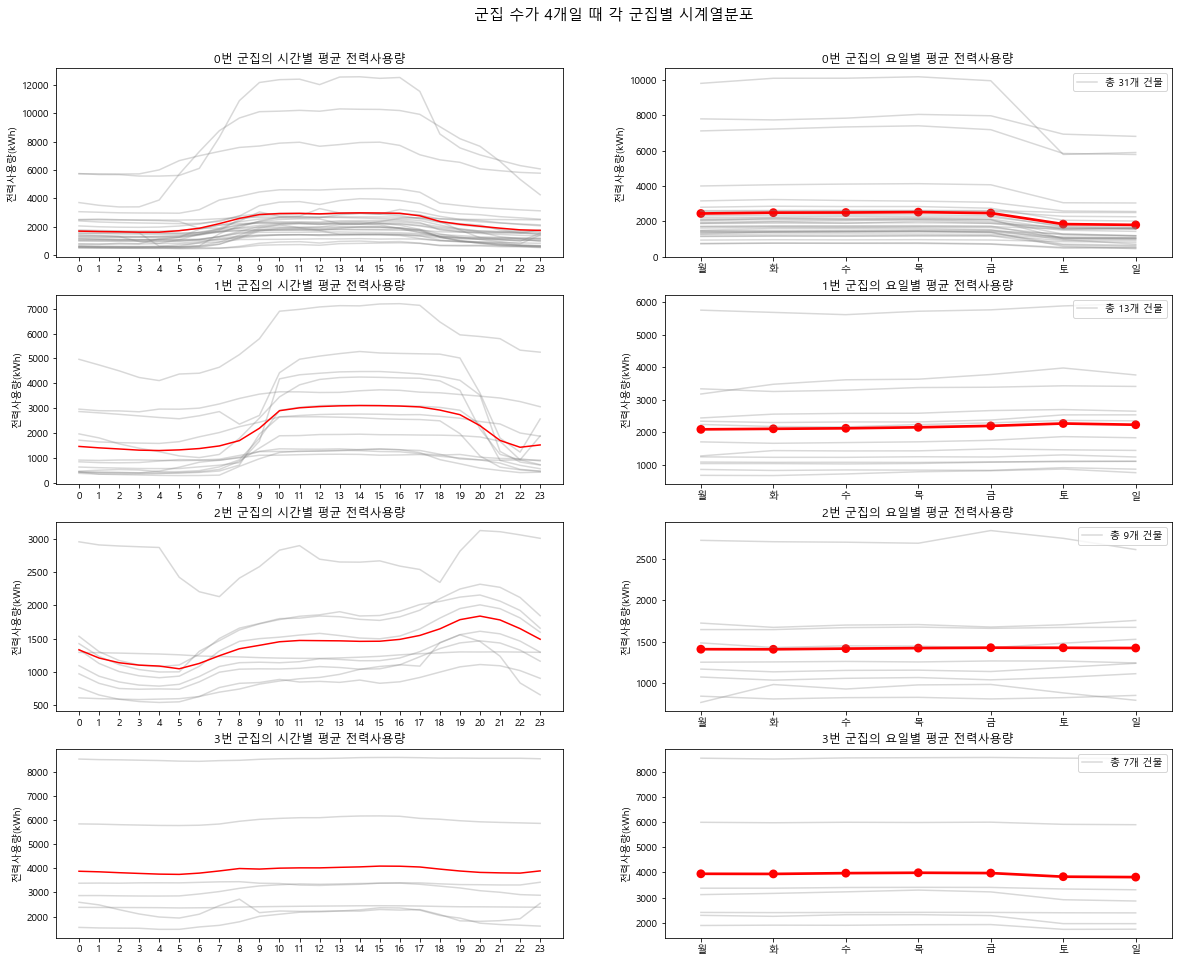

In [66]:
# 실루엣 계수가 높고 각 군집별로 건물 수가 극단적으로 치우치지 않은 
# n_cluster=4일 때를 선택하여 군집화를 진행한다.
visualize_by_cluster(train_ts, n_cluster=4, algorithm='kmeans')

In [67]:
# 각 군집별 내에서 건물들이 비슷한 패턴을 보임을 확인할 수 있다.
# - 0번 군집 : 6~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
# - 1번 군집 : 8~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
# - 2번 군집 : 저녁 시간대에 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
# - 3번 군집 : 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들

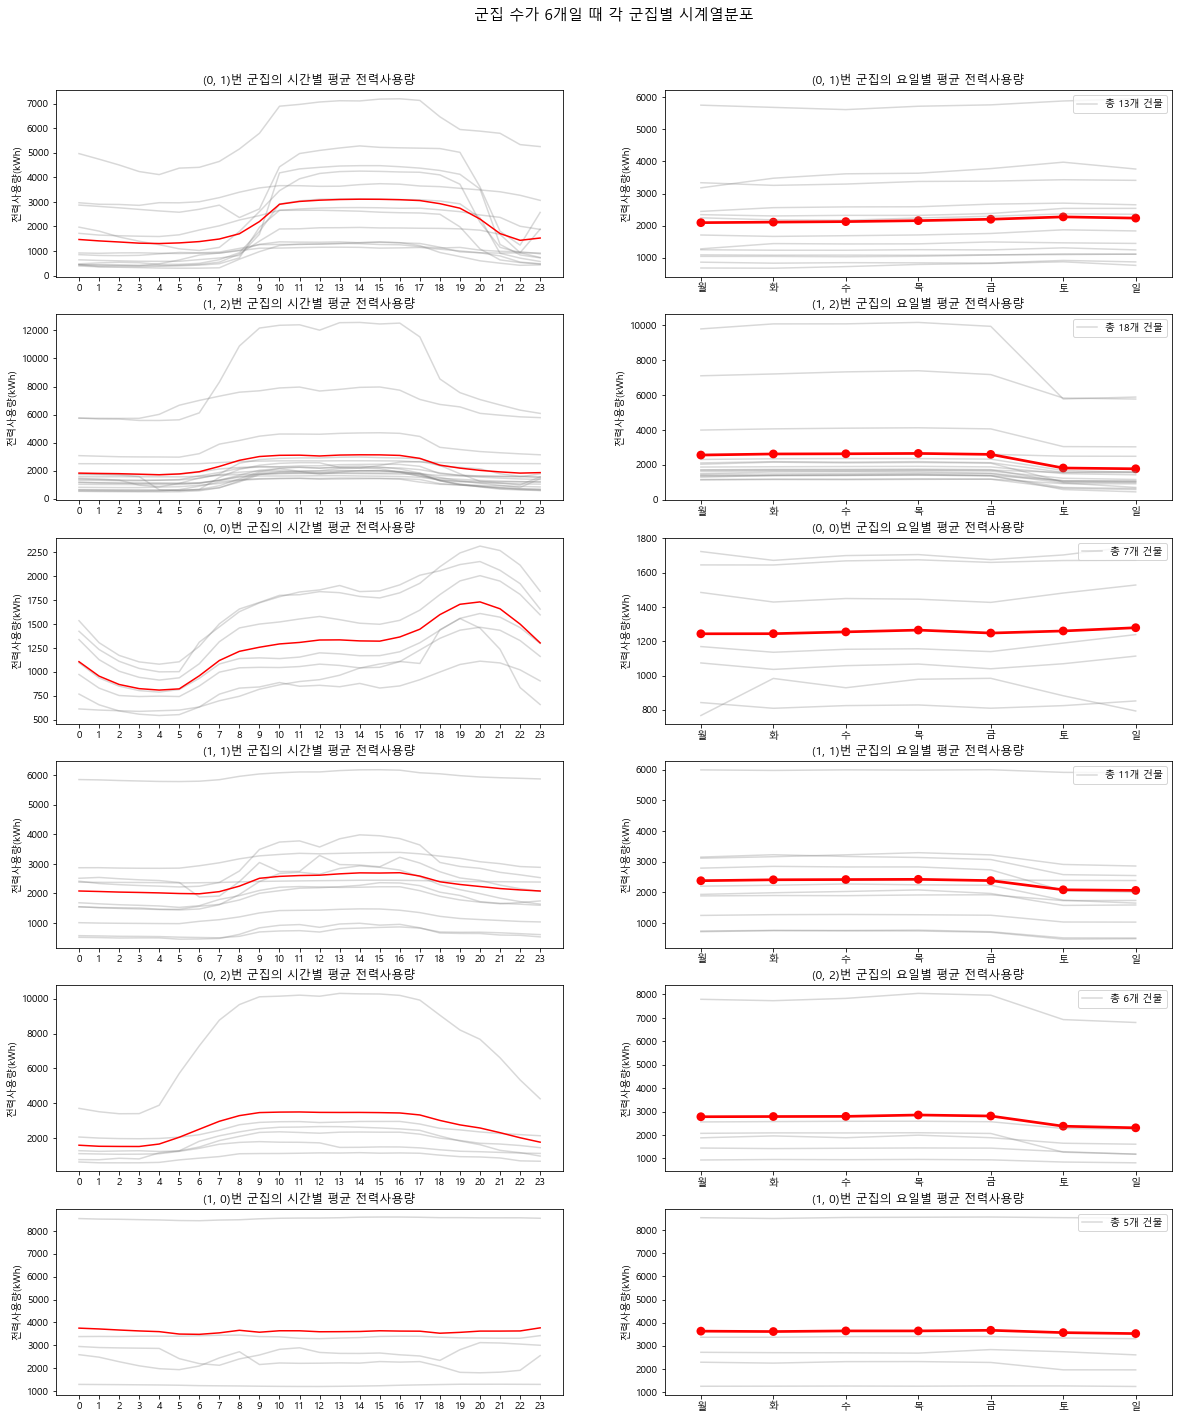

In [68]:
# 2) SOM(Self-Organizing Maps)
# 두 번째로 간단한 Neural Net인 SOM 알고리즘을 이용하여 전력사용량에 따라 건물을 군집화하였다.
# 마찬가지로 건물별 전력사용량 표준화를 진행하였고, 2x3의 그리드를 만들어 군집화하였다.

train_ts=cluster_df(scaler=StandardScaler())
X=train_ts.values

som=MiniSom(x=2,y=3,input_len=X.shape[1])
som.random_weights_init(X)
som.train(data=X,num_iteration=50000)

som_df=make_som_df(X)
visualize_by_cluster(som_df,6,algorithm='som')

In [69]:
# 마찬가지로 각 군집별 내에서 건물들이 비슷한 패턴을 보임을 확인할 수 있다.
# 각 군집에 해당되는 건물들의 용도를 IBC 용도 분류에 기반하여 추측해보았다.

# - (0,1)번 군집
    # 8~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
    # 용도 : 치료, 수용 / 상업
# - (1,2)번 군집
    # 6~18시까지 전력사용량이 많고, 줌라보다 평일의 전력사용량이 많은 건물들
    # 용도 : 업무 / 교육(학교)
# -(0,0)번 군집
    # 저녁 시간대에 전력사용량이 많은 건물들
    # 용도 : 주거 / 상업(주점)
# -(1,1)번 군집
    # 8~20시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
# -(0,2)번 군집
    # 이른 아침부터 저녁까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
    # 용도 : 공장
# -(1,0)번 군집
    # 시간별 전력사용량의 차이가 크지 않고, 줌라과 평일의 전력사용량이 비슷한 건물들
    # 용도 : 저장(창고)

## 군집의 특징 설명
## 위와 같이 시간별 전력사용량 패턴에 따라 군집을 나누면 
## 각 군집별로 다른 사업을 추진할 수 있을 것입니다.

In [70]:
### 4. 모델링 ###
# 1) LSTM
# 각 건물별로 전력사용량과의 상관관계가 0.3 이상인 변수를 이용하여 Multivariate Time Series 데이터를 
# LSTM에 적합하여 학습 및 예측을 진행한다.

In [71]:
# 건물별 모델 및 예측 결과 저장
model_history={}
forecast_future={}
predict_past={}

for num in tqdm(range(1,61)):
    
    ## 피처 골라내서 데이터프레임 만들기
    train_num1 = train_[train_.num==num]
    train_num1_corr = train_num1.corr()['전력사용량(kWh)']
    variables = train_num1_corr[abs(train_num1_corr)>0.3].keys().tolist()
    train_num1 = train_num1[variables]
    
    ## 정규화
    if train_num1.shape[1]>1:
        feature_scaler = MinMaxScaler()
        train_num1.iloc[:,:-1] = feature_scaler.fit_transform(train_num1.iloc[:,:-1])

    y_scaler = StandardScaler()
    y_scaler.fit(train_num1[['전력사용량(kWh)']])
    train_num1['전력사용량(kWh)'] = y_scaler.transform(train_num1[['전력사용량(kWh)']])

    train_num1 = train_num1.values
    
    ## 시계열 데이터 만들기
    train_X = []
    train_y = []

    n_future = 1
    n_past = 24 ## 24시간 전의 데이터까지 고려

    for i in range(n_past, len(train_num1)-n_future+1):
        train_X.append(train_num1[i-n_past:i, 0:train_num1.shape[1]])
        train_y.append(train_num1[i+n_future-1:i+n_future, -1])
    train_X, train_y = np.array(train_X), np.array(train_y)
    
    ## 모델 형성
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_y.shape[1]))
    model.compile(optimizer='adam', loss=SMAPE)

    ## 모델 학습
    history = model.fit(train_X, train_y, epochs=30, batch_size=16, validation_split=0.1, verbose=0, shuffle=False)
    model_history['num{}'.format(num)] = history
    
    ## 예측
    ### 1. 테스트데이터 예측
    n_future = 168
    forecast_period_dates = test[test.num==num]['date_time'].tolist()
    forecast = model.predict(train_X[-n_future:])
    y_pred_future = y_scaler.inverse_transform(forecast)[:,0]
    forecast_future['num{}'.format(num)] = y_pred_future
    
    ### 2. 학습데이터 예측
    predict_train = model.predict(train_X)
    predict_train = y_scaler.inverse_transform(predict_train)
    predict_train = predict_train[:,0]
    predict_past['num{}'.format(num)] = predict_train

  0%|          | 0/60 [00:00<?, ?it/s]

In [72]:
train_dates = train.date_time.unique()[24:]
test_dates = test.date_time.unique()

def vis_prediction(num):
    y_pred_future = forecast_future['num{}'.format(num)]
    predict_train = predict_past['num{}'.format(num)]
    fig = plt.figure(figsize = (7 ,4))
    plt.title(f'건물 {num} 예측 시각화', size = 15)
    sns.lineplot(x=train_dates, y=train[train.num==num]['전력사용량(kWh)'][24:], alpha=0.5, label='train기존')
    sns.lineplot(x=train_dates, y=predict_train, alpha=0.5, label='train예측')
    sns.lineplot(x=test_dates, y=y_pred_future, label='test예측')
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.show()

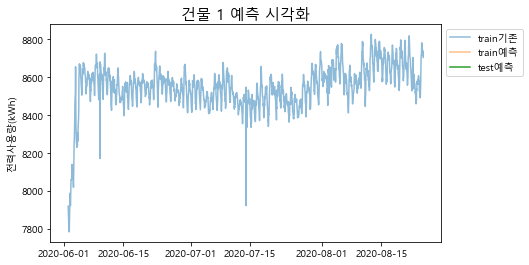

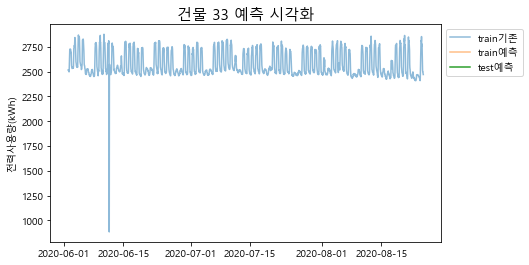

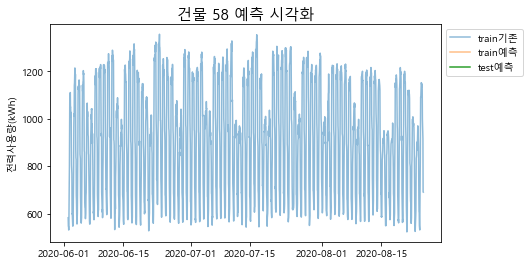

In [73]:
vis_prediction(1)
vis_prediction(33)
vis_prediction(58)

In [74]:
submission['answer']=pd.DataFrame(forecast_future).T.values.reshape(-1)

In [75]:
# 2) XGBoost
# 각 건물별로 그리드 서치를 이용해 하이퍼파라미터를 튜닝한 후, XGBoost 회귀로 학습 및 예측을 진행하였다.
# 알고리즘의 속도를 고려하여, n_estimator를 100으로 고정하고, learning_rate와 max_depth 튜닝을 진행했다.

In [77]:
# 건물별 하이퍼 파라미터 탐색
# learning_rate, max_depth 튜닝
from sklearn.model_selection import GridSearchCV
param=pd.DataFrame(np.zeros(60))
param.columns=['learning_rate']
param['max_depth']=0

for i in tqdm(range(1,61)):
    ## 피처 골라내서 데이터프레임 만들기
    train_y = pd.DataFrame(train[train['num']==i]['전력사용량(kWh)'])
    train_x = train[train['num']==i].drop(columns=['전력사용량(kWh)', '불쾌지수_c', '체감온도_b', '체감온도', 'date_time', 
                                                   'weekday','month','day', 'num','비전기냉방설비운영','태양광보유'])
    train_x = train_x
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=156)
    
    ## 모델 형성 및 학습
    model=XGBRegressor(n_estimators=100)
    xgb_param = { 
            'learning_rate': [0.01,0.05,0.1,0.2,0.3],
            'max_depth': [3, 7, 10, 15]}
    grid_xgb = GridSearchCV(model, param_grid=xgb_param, cv=5)
    grid_xgb.fit(X_train, y_train, eval_set=[ (X_test, y_test)], early_stopping_rounds=30, verbose=False)

    ## 최적 하이퍼 파라미터 저장    
    param.iloc[i-1,0] = grid_xgb.best_params_['learning_rate']
    param.iloc[i-1,1] = grid_xgb.best_params_['max_depth']

  0%|          | 0/60 [00:00<?, ?it/s]

In [78]:
# 건물별 최적 파이퍼 파라미터
# learning_rate, max_depth
param.index=list(range(1,61))
param.head()

,learning_rate,max_depth
1,0.1,7
2,0.1,7
3,0.1,7
4,0.3,10
5,0.1,7


In [79]:
# 처음에는 속도가 훨씬 빠른 LGBM을 사용하려 했으나, LGBM은 1000건 이하의 데이터 세터에서 적용할 경우 과적합이 빈번하게 발생한다.
# 반면에, XGBoost의 경우 1000개 이상의 데이터이면서 100개 이하의 변수들을 가지고 있을 때 성능이 좋다.
# 따라서, 건물별 데이터의 수(2040개)와 변수의 수(8개)를 고려하여 LGBM이 아닌 XGBoost를 이용항 모델링을 진해아혔다.
# 과적합 방지를 위해 K-Fold 교차검증을 진행하였다.

In [87]:
sub = []
for i in tqdm(range(1,61)):
    ## 피처 골라내서 데이터프레임 만들기
    train_y = pd.DataFrame(train[train['num']==i]['전력사용량(kWh)'])
    train_x = train[train['num']==i].drop(columns=['전력사용량(kWh)', '불쾌지수_c', '체감온도_b', '체감온도', 'date_time', 
                                                   'weekday','month','day', 'num','비전기냉방설비운영','태양광보유'])
    
    ## K-Fold 교차 검증
    cross=KFold(n_splits=5, shuffle=True, random_state=156)
    folds=[]
    for train_idx, valid_idx in cross.split(train_x, train_y):
        folds.append((train_idx, valid_idx))
    models={}
    for fold in range(5):
        train_idx, valid_idx=folds[fold]
        X_train, y_train, X_valid, y_valid = train_x.iloc[train_idx, :], train_y.iloc[train_idx, :], train_x.iloc[valid_idx, :], train_y.iloc[valid_idx, :]
       ## 모델 형성 및 학습
        model=XGBRegressor(n_estimators=1000, learning_rate = param.iloc[i-1,0], max_depth = param.iloc[i-1,1])
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=30, verbose=False)
        models[fold]=model

    ## 예측    
    test_ = test[test['num']==i].drop(columns=['date_time', 'weekday','month','day','num','체감온도','비전기냉방설비운영','태양광보유'])
    sub_ = pd.DataFrame(np.zeros(168))
    sub_.columns = ['answer']
    for h in range(5):
        sub_['answer'] += models[h].predict(test_)/5 
    sub.append(sub_['answer'])

  0%|          | 0/60 [00:00<?, ?it/s]

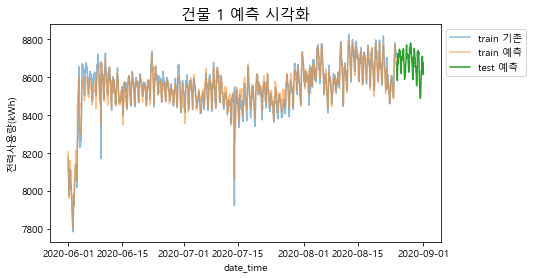

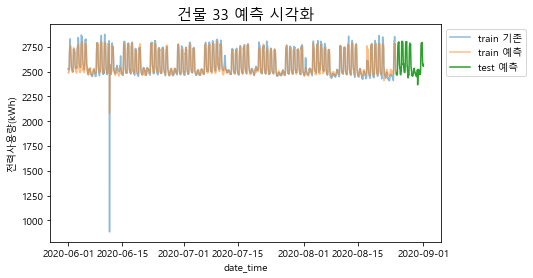

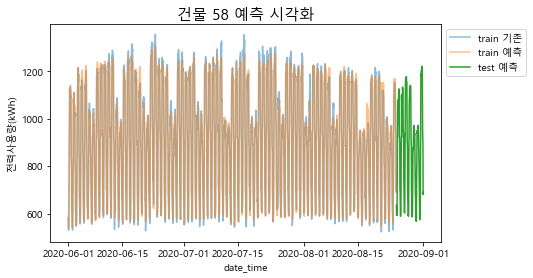

In [88]:
# 건물 1,33,58 예측 시각화
num = [1, 33, 58]

for i in num:
    sub = []
    sub1 = []
    ## 피처 골라내서 데이터프레임 만들기
    train_y = pd.DataFrame(train[train['num']==i]['전력사용량(kWh)'])
    train_x = train[train['num']==i].drop(columns=['전력사용량(kWh)', 'date_time', '불쾌지수_c', '체감온도_b', '체감온도', 
                                                   'weekday','month','day', 'num','비전기냉방설비운영','태양광보유'])
    
    ## K-Fold 교차 검증
    cross=KFold(n_splits=5, shuffle=True, random_state=156)
    folds=[]
    for train_idx, valid_idx in cross.split(train_x, train_y):
        folds.append((train_idx, valid_idx))
    models={}
    for fold in range(5):
        train_idx, valid_idx=folds[fold]
        X_train,y_train,X_valid,y_valid = train_x.iloc[train_idx, :],train_y.iloc[train_idx, :],train_x.iloc[valid_idx, :],train_y.iloc[valid_idx, :]
        
       ## 모델 형성 및 학습
        model=XGBRegressor(n_estimators=1000, learning_rate = param.iloc[i-1,0], max_depth = param.iloc[i-1,1])
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], early_stopping_rounds=30, verbose=False)
        models[fold]=model

    for h in range(5):
        sub_['answer'] += models[h].predict(test_)/5 
    sub1.append(sub_['answer'])
    
    ## test 예측    
    test_ = test[test['num']==i].drop(columns=['date_time','weekday','month','day','num','체감온도','비전기냉방설비운영','태양광보유'])
    sub_ = pd.DataFrame(np.zeros(168))
    sub_.columns = ['answer']
    for h in range(5):
        sub_['answer'] += models[h].predict(test_)/5 
    sub.append(sub_['answer'])
    
    ## train 예측
    train_ = train_x
    sub_1 = pd.DataFrame(np.zeros(2040))
    sub_1.columns = ['answer']
    for h in range(5):
        sub_1['answer'] += models[h].predict(train_x)/5 
    sub1.append(sub_1['answer'])
        # 시각화 범위와 일치하는 시간 정보 추출
    time = pd.DataFrame(train[train['num']==i]['date_time'])
    time = time.reset_index(drop=True)
    time1 = pd.DataFrame(test[test['num']==i]['date_time'])
    time1 = time1.reset_index(drop=True)

    #시각화
    train_y1 = train_y.reset_index()
    fig = plt.figure(figsize = (7 ,4))
    plt.title(f'건물 {i} 예측 시각화', size = 15)
    sns.lineplot(x = time['date_time'], y = train_y1['전력사용량(kWh)'],alpha=0.5, label = 'train 기존')
    sns.lineplot(x = time['date_time'], y = sub_1['answer'], alpha=0.5, label = 'train 예측')
    sns.lineplot(x = time1['date_time'], y = sub_['answer'], label = 'test 예측')
    plt.xticks()
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.show()

In [89]:
# 마찬가지로, train 범위에서 기존의 데이터와 예측값이 대체로 겹치는 것으로 보아 학습이 제대로 된 것을 알 수 있다. 
# 또한, test 범위에서도 train 데이터와 매끄럽게 이어지는 것을 확인할 수 있다.